In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


In [2]:
torch.cuda.set_device(0)

In [3]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds, optim = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(), linear_ffn=(), with_data=True, with_optim=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


(tensor(4.1686e-05, grad_fn=<MeanBackward0>),
 tensor(2.2291, grad_fn=<MeanBackward0>))

In [4]:
outputs_list[0]['input'][0, 0, :10], outputs_list[0]['attn_output_add_res'][0, 0, :10], outputs_list[0]['output'][0, :10, :].norm(dim=-1), outputs_list[1]['value_states'][0, 0, :10, :].norm(dim=-1), outputs_list[1]['attn_logits'][0, 0, :10, 0]

(tensor([ 0.1625,  0.3798, -0.2718,  2.1928, -0.5032,  0.4220,  0.4536,  0.7264,
         -0.2310, -0.4573], grad_fn=<SliceBackward0>),
 tensor([  0.2434,  -0.5843,  -0.5185,   3.4976,  -1.2099,  -0.5731,  -0.2012,
           0.2715,  -1.7475, -12.9446], grad_fn=<SliceBackward0>),
 tensor([135.6272,  27.2625,  16.3049,  28.2031,  49.5698,  33.8267,  33.0718,
          15.3098,  33.0708,  34.1695], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ 0.7551, 28.5901, 10.6723, 28.4080, 16.7570, 20.8605, 24.4004, 11.8640,
         23.9386, 24.3867], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ -1.6425,  28.8882, -15.9288,  26.3170,  15.1818,  20.5725,  21.0230,
          -9.5778,  21.7429,  17.0595], grad_fn=<SelectBackward0>))

In [6]:
hook_dict = {"basic": hook, "no_attn_0": check_embed(target_layers=[0, 1, 2], target_heads=[(0, 0)], target_mlp_layers=[]), "no_mlp_0": check_embed(target_layers=[0, 1, 2], target_heads=[], target_mlp_layers=[0])}
keys = ["icl_risk", "markov_risk", "bos_attn", "output_norm", "value_norm", "output_state", "value_state", "attn_logits"]

In [11]:
from tqdm import tqdm
summary_dynamic_traj = {}
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
with torch.no_grad():
    for step in tqdm(torch.arange(100, 9701, 120)):
        model, _, _, _, _ = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=step, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
        summary_dynamic_traj[step.item()] = get_dynamic_summary(ds, x, model, hook_dict, keys, probs, triggers_pos)

100%|██████████| 81/81 [08:16<00:00,  6.12s/it]


### start from here if recomputing is not requried

In [7]:
keys = ["icl_risk", "markov_risk", "bos_attn", "output_norm", "value_norm", ]
summary_dynamic_traj = torch.load("/data/tianyu/birth/dynamics/summary_dynamic_traj.pt")
step_list, summary_concat = concat_summary(summary_dynamic_traj, hook_dict, keys=keys, )

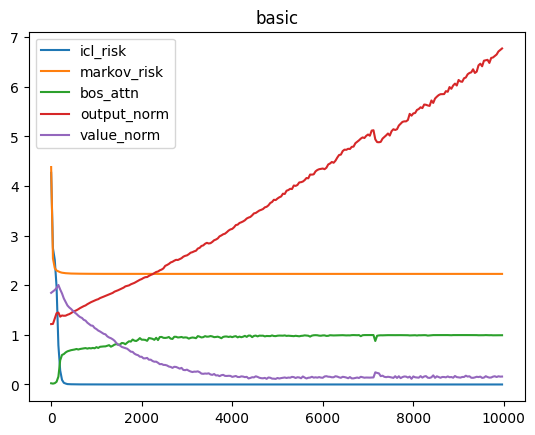

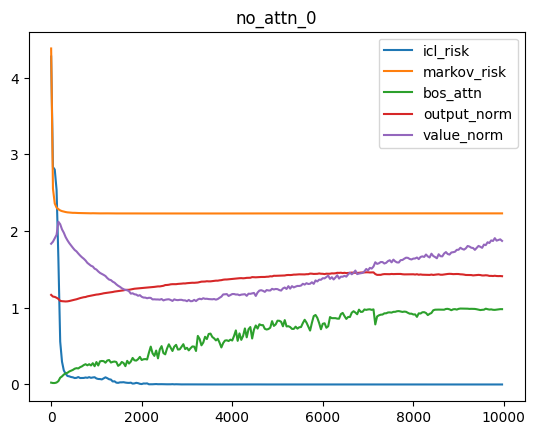

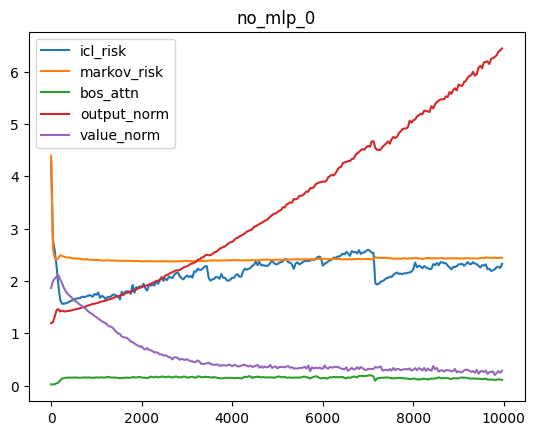

In [8]:
left_end = -1
for hook_name in hook_dict.keys():
    for key in ["icl_risk", "markov_risk", "bos_attn", "output_norm", "value_norm"]:
        if key == "output_norm":
            plt.plot(step_list[:left_end], summary_concat[hook_name][key][:left_end, 0]/20, label=key)
        elif key == "value_norm":
            plt.plot(step_list[:left_end], summary_concat[hook_name][key][:left_end, 0]/5, label=key)
        elif key == "attn_logits":
            plt.plot(step_list[:left_end], summary_concat[hook_name][key][:left_end, 1]/5, label=key)
        else:
            plt.plot(step_list[:left_end], summary_concat[hook_name][key][:left_end], label=key)
    # plt.gca().set_xscale('log')
    plt.legend()
    plt.title(hook_name)
    plt.show()

In [22]:
outputs_list[0]['attn_output'][0, 0, :].shape

torch.Size([256])

In [28]:
import torch.nn.functional as F
F.cosine_similarity(outputs_list[0]['input'][0, 0, :], outputs_list[0]['attn_output'][0, 0, :], dim=0)

tensor(0.5121, grad_fn=<SumBackward1>)

## seems that the small value states and the massive norm are binded?

## check the norm of the 1L1H

In [82]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
# run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(), no_ffn=(), linear_ffn=(), with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
triggers_pos = ds.get_triggers_pos(x)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(7.7643e-05, grad_fn=<MeanBackward0>),
 tensor(2.2295, grad_fn=<MeanBackward0>))

In [83]:
outputs_list[0]['value_states'][0, 0, :10, :].norm(dim=-1), outputs_list[0]['attn_logits'][0, 0, :10, 0]

(tensor([ 1.4973, 22.5760,  8.2080, 21.3069, 13.2921, 14.1239, 14.9679,  9.7751,
         15.8170, 15.1413], grad_fn=<LinalgVectorNormBackward0>),
 tensor([ -3.5419,  16.5308, -16.6427,  19.2047,  17.8734,  18.7529,  22.1294,
         -11.3287,  24.6246,  19.4592], grad_fn=<SelectBackward0>))

### Intuition: it's hard to get really really small value states norm due to imperfect orthogonality, so massive norm comes out to help

### new intuition: maybe the massive norms contributes to the large logits!

### experiments to try: try long-ranged training, try training few parameter models, and record the increasing of logits

## PCA

In [45]:
output_state = summary_concat['basic']['output_state']
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(output_state)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', edgecolor='k', s=100)

# Look into the gradients to see which component contributes a constant gradient to the bos norm

In [6]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
grads_norm_traj = {}
for step in tqdm(torch.arange(0, 9601, 120)):
    run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
    # run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
    model, cfg, x, y, ds, optim = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=step, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(), linear_ffn=(), with_data=True, with_optim=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
    hook = forward_hook([], '')
    pred, outputs_list = model.modified_forward_with_hook(x, hook)
    model.train()
    pred = model(x)
    loss = F.cross_entropy(pred.flatten(0, 1), y.flatten(0, 1))
    loss.backward()
    ## get the gradient of the loss with respect to the output of the last layer
    grads = {}
    for name, param in model.named_parameters():
        grads[name] = param.grad
    grads_norm = {}
    for name, grad in grads.items():
        if grad is not None:
            grads_norm[name] = grad.norm()
    grads_norm_traj[step.item()] = grads_norm

  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [08:11<00:00,  6.07s/it]


In [9]:
grads_list = {}
for name in grads_norm_traj[0].keys():
    grads_list[name] = [grads_norm_traj[step.item()][name] for step in torch.arange(0, 9601, 120)]

In [25]:
grads_list.keys()

dict_keys(['tok_embeddings.weight', 'pos_embeddings.weight', 'layers.0.attention.wq.weight', 'layers.0.attention.wk.weight', 'layers.0.attention.wv.weight', 'layers.0.attention.wo.weight', 'layers.0.ff.w1.weight', 'layers.0.ff.w2.weight', 'layers.0.attention_norm.weight', 'layers.0.attention_norm.bias', 'layers.0.ff_norm.weight', 'layers.0.ff_norm.bias', 'layers.1.attention.wq.weight', 'layers.1.attention.wk.weight', 'layers.1.attention.wv.weight', 'layers.1.attention.wo.weight', 'layers.1.ff.w1.weight', 'layers.1.ff.w2.weight', 'layers.1.attention_norm.weight', 'layers.1.attention_norm.bias', 'layers.1.ff_norm.weight', 'layers.1.ff_norm.bias', 'layers.2.ff.w1.weight', 'layers.2.ff.w2.weight', 'layers.2.ff_norm.weight', 'layers.2.ff_norm.bias', 'norm.weight', 'norm.bias', 'output.weight'])

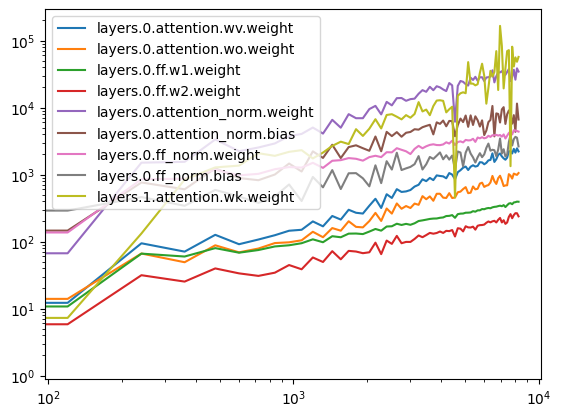

In [32]:
name_list = ['layers.0.attention.wv.weight', 'layers.0.attention.wo.weight', 'layers.0.ff.w1.weight', 'layers.0.ff.w2.weight', 'layers.0.attention_norm.weight', 'layers.0.attention_norm.bias', 'layers.0.ff_norm.weight', 'layers.0.ff_norm.bias', 'layers.1.attention.wk.weight']
last_idx = 70
for name in name_list:
    plt.plot(torch.arange(0, 9601, 120)[:last_idx], 1/np.array(grads_list[name][:last_idx]), label=name)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.legend()
plt.show()

## check the change of the norm of wv and wo along training dynamics

In [11]:
# run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_k3_bos1"
wvo_norm = {}
for step in tqdm(torch.arange(0, 9601, 120)):
    run_path_server = "/data/tianyu/birth/gens/pre-iclr/dynamics/dormant_copy_simplified"
    # run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
    model, cfg, x, y, ds, optimizer = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server, bos_num=1, train_steps=step, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=(2, ), no_ffn=(), linear_ffn=(), with_data=True, with_optim=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu/birth/data")
    v_pre = model.layers[0].attention.wv.weight.clone().detach()
    o_pre = model.layers[0].attention.wo.weight.clone().detach()

    model.train()
    optimizer.zero_grad()
    pred = model(x)

    loss = F.cross_entropy(pred.flatten(0, 1), y.flatten(0, 1))
    loss.backward()
    wvo_norm[step.item()] = {'v': torch.linalg.norm(model.layers[0].attention.wv.weight, ord=2).item(), 'o': torch.linalg.norm(model.layers[0].attention.wo.weight, ord=2).item(), 'v_grad': torch.linalg.norm(model.layers[0].attention.wv.weight.grad, ord=2).item(), 'o_grad': torch.linalg.norm(model.layers[0].attention.wo.weight.grad, ord=2).item()}
    optimizer.step()

    v_post = model.layers[0].attention.wv.weight.clone().detach()
    o_post = model.layers[0].attention.wo.weight.clone().detach()

    wvo_norm[step.item()]['v_update'] = torch.linalg.norm(v_post - v_pre, ord=2).item()
    wvo_norm[step.item()]['o_update'] = torch.linalg.norm(o_post - o_pre, ord=2).item()


  0%|          | 0/81 [00:00<?, ?it/s]

100%|██████████| 81/81 [06:59<00:00,  5.18s/it]


In [12]:
torch.save(wvo_norm, "/data/tianyu/birth/dynamics/wvo_norm.pt")

In [13]:
wv_norm = [wvo_norm[step.item()]['v'] for step in torch.arange(0, 9601, 120)]
wo_norm = [wvo_norm[step.item()]['o'] for step in torch.arange(0, 9601, 120)]
wv_grad = [wvo_norm[step.item()]['v_grad'] for step in torch.arange(0, 9601, 120)]
wo_grad = [wvo_norm[step.item()]['o_grad'] for step in torch.arange(0, 9601, 120)]
wv_update = [wvo_norm[step.item()]['v_update'] for step in torch.arange(0, 9601, 120)]
wo_update = [wvo_norm[step.item()]['o_update'] for step in torch.arange(0, 9601, 120)]

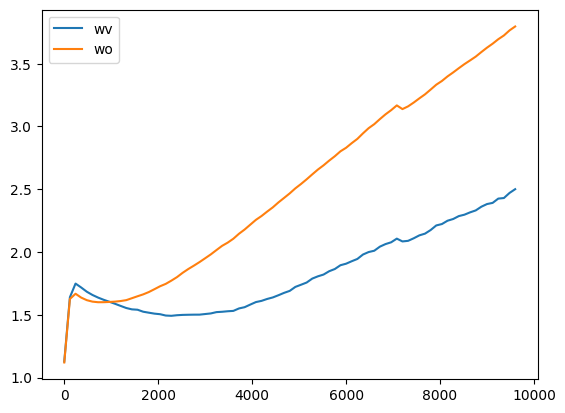

In [14]:
plt.plot(wvo_norm.keys(), wv_norm, label='wv')
plt.plot(wvo_norm.keys(), wo_norm, label='wo')
plt.legend()
plt.show()

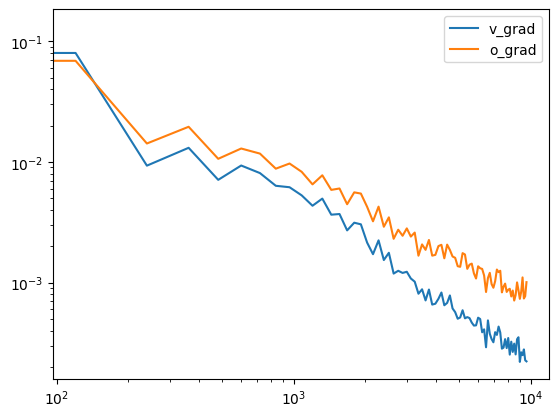

In [15]:
# plt.plot(wvo_norm.keys(), wv_norm, label='wv')
# plt.plot(wvo_norm.keys(), wo_norm, label='wo')
plt.plot(wvo_norm.keys(), wv_grad, label='v_grad')
plt.plot(wvo_norm.keys(), wo_grad, label='o_grad')
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.legend()
plt.show()

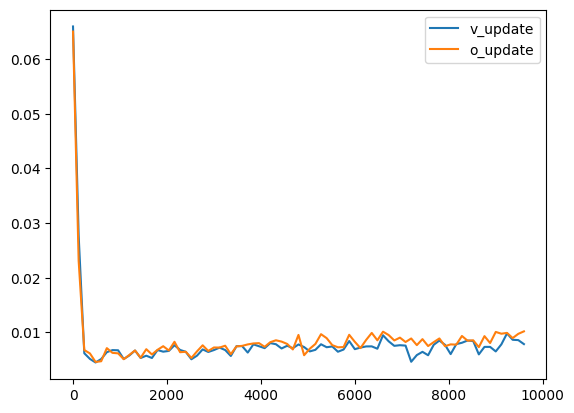

In [17]:
plt.plot(wvo_norm.keys(), wv_update, label='v_update')
plt.plot(wvo_norm.keys(), wo_update, label='o_update')
# plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')
plt.legend()
plt.show()

In [18]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0.0001
)